In [1]:
%env CUDA_VISIBLE_DEVICES=0
import os
import re
import sys
sys.path.append('/home/a_razumov/projects/k-space-mri')
import numpy as np
import pylab as plt
plt.style.use('bmh')
import pandas as pd
import seaborn as sns
import h5py
import nibabel
import pickle
from tqdm.notebook import tqdm

import torch
import torchvision
import torch.nn.functional as F
import torch.utils.data
import torchvision.transforms as transforms


from k_space_reconstruction.utils.metrics import pt_msssim, pt_ssim
from k_space_reconstruction.utils.kspace import EquispacedMaskFunc, RandomMaskFunc
from k_space_reconstruction.utils.kspace import pt_spatial2kspace as Ft
from k_space_reconstruction.utils.kspace import pt_kspace2spatial as IFt
from k_space_reconstruction.nets.unet import Unet

from os.path import isdir, join

env: CUDA_VISIBLE_DEVICES=0


In [2]:
fig_bezzeless = lambda nc, nr : plt.subplots(ncols=nc, nrows=nr, figsize=(4 * nc, 4), dpi=120, 
                                             subplot_kw=dict(frameon=False, xticks=[], yticks=[]), 
                                             gridspec_kw=dict(wspace=0.0, hspace=0.0))


def ce_loss(true, logits, weights, ignore=255):
    torch.nn.CrossEntropyLoss
    ce_loss = torch.nn.functional.cross_entropy(
        logits.float(),
        true.long(),
        ignore_index=ignore,
        weight=weights,
    )
    return ce_loss


def dice_loss(true, logits, eps=1e-7):
    num_classes = logits.shape[1]
    if num_classes == 1:
        true_1_hot = torch.eye(num_classes + 1)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        true_1_hot_f = true_1_hot[:, 0:1, :, :]
        true_1_hot_s = true_1_hot[:, 1:2, :, :]
        true_1_hot = torch.cat([true_1_hot_s, true_1_hot_f], dim=1)
        pos_prob = torch.sigmoid(logits)
        neg_prob = 1 - pos_prob
        probas = torch.cat([pos_prob, neg_prob], dim=1)
    else:
        true_1_hot = torch.eye(num_classes)[true.squeeze(1)]
        true_1_hot = true_1_hot.permute(0, 3, 1, 2).float()
        probas = torch.nn.functional.softmax(logits, dim=1)
    true_1_hot = true_1_hot.type(logits.type())
    dims = (0,) + tuple(range(2, true.ndimension()))
    intersection = torch.sum(probas * true_1_hot, dims)
    cardinality = torch.sum(probas + true_1_hot, dims)
    dice_loss = (2. * intersection / (cardinality + eps)).mean()
    return (1 - dice_loss)

def dice_coeffs(true, logits):
    num_classes = logits.shape[1]
    probas = F.softmax(logits, dim=1)
    probas[probas > 0.5] = 1; probas[probas <= 0.5] = 0
    pmask = torch.zeros_like(true).float()
    for i in range(1, num_classes):
        pmask[:,0] += i * probas[:,i]
    dice_ls = []
    for i in range(1, num_classes):
        yt = (true==i).float().flatten()
        yp = (pmask==i).float().flatten()
        intersection = torch.sum(yt * yp)
        cardinality = torch.sum(yt + yp)
        dice_ls.append((2. * intersection / (cardinality + 1e-7)).item())
    return dice_ls        

def train_sampling_pattern(train_generator, model, n=14):
    c, bmasks, images, bmean, bstd = next(iter(train_generator))
    bks = Ft(images * bstd + bmean)
    bgt = IFt(bks).abs()
    w = torch.zeros(256).cuda().float()
    w[128] = 1
    bbatch = 32
    w_list = []
    pbar = tqdm(range(n))
    for count in pbar:
        w = torch.autograd.Variable(w, requires_grad=True)
        for j in range(bks.shape[0] // bbatch):
            bbks = bks[bbatch*j:bbatch*(j+1)].cuda()
            bbgt = bgt[bbatch*j:bbatch*(j+1)].cuda()
            bbmean = bmean[bbatch*j:bbatch*(j+1)].cuda()
            bbstd = bstd[bbatch*j:bbatch*(j+1)].cuda()
            bbmasks = bmasks[bbatch*j:bbatch*(j+1)].cuda()
            recs = IFt(bbks * w).abs()
            pm = model((recs - bbmean) / (bbstd + 1e-11))
            loss = dice_loss(bbmasks.long(), pm)
            loss.backward()
        for i in torch.topk(w.grad, 256, largest=False).indices:
            if w[i] == 0: 
                w = w.detach()
                w[i] = 1.
                w_list.append(w.clone())
                pbar.set_description('select: %d, loss: %.6f' % (i.item(), loss.item()))
                break
    return w_list

def test_sampling_pattern(sampling, model, val_generator):
    vc, vbmasks, vimages, vbmean, vbstd = next(iter(val_generator))
    vbks = Ft(vimages * vbstd + vbmean)
    vbgt = IFt(vbks).abs()
    dice_scores = []
    bbatch = 32
    for j in tqdm(range(vbks.shape[0] // bbatch), disable=True):
        vbbks = vbks[bbatch*j:bbatch*(j+1)].cuda()
        vbbgt = vbgt[bbatch*j:bbatch*(j+1)].cuda()
        vbbmean = vbmean[bbatch*j:bbatch*(j+1)].cuda()
        vbbstd = vbstd[bbatch*j:bbatch*(j+1)].cuda()
        vbbmasks = vbmasks[bbatch*j:bbatch*(j+1)].cuda()
        with torch.no_grad():
            # igs
            recs = IFt(vbbks * sampling).abs()
            pm = model((recs - vbbmean) / (vbbstd + 1e-11))
            for i in range(recs.shape[0]):
                dice_scores.append(1 - dice_loss(vbbmasks.long(), pm).item())
    return dice_scores

def test_on_classes_sampling_pattern(sampling, model, val_generator):
    vc, vbmasks, vimages, vbmean, vbstd = next(iter(val_generator))
    vbks = Ft(vimages * vbstd + vbmean)
    vbgt = IFt(vbks).abs()
    dice_scores = []
    ssim_scores = []
    bbatch = 1
    for j in tqdm(range(vbks.shape[0] // bbatch), disable=True):
        vbbks = vbks[bbatch*j:bbatch*(j+1)].cuda()
        vbbgt = vbgt[bbatch*j:bbatch*(j+1)].cuda()
        vbbmean = vbmean[bbatch*j:bbatch*(j+1)].cuda()
        vbbstd = vbstd[bbatch*j:bbatch*(j+1)].cuda()
        vbbmasks = vbmasks[bbatch*j:bbatch*(j+1)].cuda()
        with torch.no_grad():
            # igs
            recs = IFt(vbbks * sampling).abs()
            pm = model((recs - vbbmean) / (vbbstd + 1e-11))
            for i in range(recs.shape[0]):
                dice_scores.append(dice_coeffs(vbbmasks.long(), pm))
                ssim_scores.append(pt_ssim(vbbgt, recs).item())
    return {'dice': np.array(dice_scores), 'ssim': np.array(ssim_scores)}

def finetune_model_on_sampling(train_generator, model, sampling, epochs=5, return_losses=False):
    if not os.path.exists('acdc_unet_checkpoints'):
        os.makedirs('acdc_unet_checkpoints')
    losses = np.zeros(epochs)
    checkpoints = []
    criterion = lambda p,t : dice_loss(t, p) * .75 + ce_loss(t.squeeze(1), p, weights=None) * .25
    metric = lambda p,t : 1 - dice_loss(t, p)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    pbar = tqdm(range(epochs))
    for epoch in pbar:
        model = model.train()
        for _, targets, images, means, stds in train_generator:
            images = images.cuda(); targets = targets.cuda().long(); means = means.cuda(); stds = stds.cuda()
            optimizer.zero_grad()
            # backpropagate
            images = (IFt(Ft(images * stds + means) * sampling).abs() - means) / (stds + 1e-11)
            pred = model(images)
            loss = criterion(pred, targets)
            loss.backward()
            optimizer.step()
            losses[epoch] += loss.item() / len(train_generator)
        model = model.train(False).eval()
        checkpoint_path = join('acdc_unet_checkpoints', 'epoch%d.pth' % epoch)
        torch.save(model.state_dict(), checkpoint_path)
        checkpoints.append(checkpoint_path)
    del optimizer
    best_checkpoint = checkpoints[np.argmin(losses)]
    model.load_state_dict(torch.load(best_checkpoint))
    if return_losses:
        return model, losses
    else:
        return model


class ACDCDataset(torch.utils.data.Dataset):
    CLASSES = {0: 'NOR', 1: 'MINF', 2: 'DCM', 3: 'HCM', 4: 'RV'}

    def __init__(self, hf_path: str):
        super().__init__()
        self.hf = h5py.File(hf_path)

    def __len__(self) -> int:
        return len(self.hf)

    def __getitem__(self, item: int):
        img = self.hf[str(item)][:1]
        mask = self.hf[str(item)][1:]
        c = self.hf[str(item)].attrs['class']
        img = torch.tensor(img).float()
        mask = torch.tensor(mask)
        mean = img.mean()
        std = img.std()
        img = (img - mean) / (std + 1e-11)
        return c, mask, img, mean.unsqueeze(0).unsqueeze(0).unsqueeze(0), std.unsqueeze(0).unsqueeze(0).unsqueeze(0)

In [3]:
def pt_psnr(img1, img2, maxval):
    mse = torch.mean((img1 - img2) ** 2)
    return 20 * torch.log10(maxval / torch.sqrt(mse))

In [4]:
train_dataset = ACDCDataset('/home/a_razumov/small_datasets/acdc_seg_h5/train.h5')
val_dataset = ACDCDataset('/home/a_razumov/small_datasets/acdc_seg_h5/val.h5')
train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True, num_workers=6)
val_generator = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)

In [5]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = Unet(1, 3+1).to(device).train(False).eval()
for p in model.parameters():
    p.requires_grad = False
model.load_state_dict(torch.load('unet-acdc-norot.pt'))

<All keys matched successfully>

# Acceleration curve

In [6]:
def get_acceleration_scores(acceleration_factor, train_dataset, val_generator):
    # init sampling masks
    fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.02], [acceleration_factor])((256, 256))[0]).cuda().float()
    zm = torch.zeros(256).cuda().float()
    zm[256//2 - int(fastmri_mask_x16.sum())//2 : 256//2 + int(fastmri_mask_x16.sum())//2] = 1
    fm = torch.ones(256).cuda().float()
    # load models
    model_zm = Unet(1, 3+1).to(device).train(False).eval()
    model_zm.load_state_dict(torch.load('unet-acdc-norot.pt'))
    model_igs = Unet(1, 3+1).to(device).train(False).eval()
    model_igs.load_state_dict(torch.load('unet-acdc-norot.pt'))
    model_fastmri = Unet(1, 3+1).to(device).train(False).eval()
    model_fastmri.load_state_dict(torch.load('unet-acdc-norot.pt'))
    # train our sampling
    tg = torch.utils.data.DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
    w = train_sampling_pattern(tg, model_igs, n=int(fastmri_mask_x16.sum()))[int(fastmri_mask_x16.sum() - 2)]
    # finetune models
    tg = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
    model_igs = finetune_model_on_sampling(tg, model_igs, w, epochs=25)
    model_zm = finetune_model_on_sampling(tg, model_zm, zm, epochs=25)
    model_fastmri = finetune_model_on_sampling(tg, model_fastmri, fastmri_mask_x16, epochs=25)
    scores = dict(
        fastmri=test_on_classes_sampling_pattern(fastmri_mask_x16, model_fastmri, val_generator), 
        center=test_on_classes_sampling_pattern(zm, model_zm, val_generator),
        ours=test_on_classes_sampling_pattern(w, model_igs, val_generator),
    )
    return scores

In [ ]:
from collections import defaultdict
from sklearn.model_selection import KFold

acceleration_fold_curve = []
acc_vals = [2,4,6,8,10,12,14,16,18,20,24,26]

fastmri_mask_x16 = torch.tensor(EquispacedMaskFunc([0.04], [16])((256, 256))[0]).cuda().float()
zm = torch.zeros(256).cuda().float()
zm[256//2 - int(16)//2 : 256//2 + int(16)//2] = 1
fm = torch.ones(256).cuda().float()

for i, (train_id, val_id) in enumerate(KFold(shuffle=False).split(range(len(train_dataset)))):
    td = torch.utils.data.Subset(train_dataset, train_id)
    vd = torch.utils.data.Subset(train_dataset, val_id)
    tg = torch.utils.data.DataLoader(td, batch_size=len(td), shuffle=True)
    vg = torch.utils.data.DataLoader(vd, batch_size=len(vd), shuffle=False)
    fold_curve = []
    for ax in tqdm(acc_vals):
        fold_curve.append((ax, get_acceleration_scores(ax, td, vg)))
    acceleration_fold_curve.append(fold_curve)
with open('acceleration_fold_finetune_curve.pkl', mode='wb') as f: pickle.dump(acceleration_fold_curve, f)

In [8]:
with open('acceleration_fold_finetune_curve.pkl', mode='rb') as f: acceleration_fold_curve = pickle.load(f)

In [9]:
len(acceleration_fold_curve), len(acceleration_fold_curve[0])

(5, 12)

In [10]:
acceleration_fold_curve[0][4][0]

10

In [11]:
np.mean(acceleration_fold_curve[0][4][1]['center']['ssim']), np.mean(acceleration_fold_curve[0][4][1]['center']['dice'])

(0.6448398697025636, 0.7747659865918071)

In [12]:
np.mean(acceleration_fold_curve[0][4][1]['ours']['ssim']), np.mean(acceleration_fold_curve[0][4][1]['ours']['dice'])

(0.6631276781569008, 0.7815656794720337)

In [13]:
import itertools
dice_ssim_folds = pd.DataFrame.from_dict(dict(
    dice = list(itertools.chain.from_iterable(
        [np.mean(ax[k]['dice']) for _, ax in fd] for k in ['center', 'fastmri', 'ours'] for fd in acceleration_fold_curve
    )),
    ssim = list(itertools.chain.from_iterable(
        [np.mean(ax[k]['ssim']) for _, ax in fd] for k in ['center', 'fastmri', 'ours'] for fd in acceleration_fold_curve
    )),
    ax = list(itertools.chain.from_iterable(
        [ax_val for ax_val, _ in fd] for k in ['center', 'fastmri', 'ours'] for fd in acceleration_fold_curve
    )),
    sampling = list(itertools.chain.from_iterable(
        [k for _, ax in fd] for k in ['center', 'fastmri', 'ours'] for fd in acceleration_fold_curve
    )),
    fold = list(itertools.chain.from_iterable(
        [i for _, ax in fd] for k in ['center', 'fastmri', 'ours'] for i, fd in enumerate(acceleration_fold_curve)
    )),
))

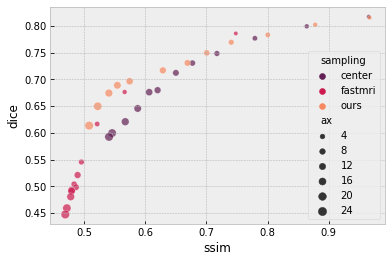

In [15]:
sns.scatterplot(data=dice_ssim_folds.groupby(['ax', 'sampling']).mean(), x='ssim', y='dice', hue='sampling', size='ax', alpha=0.7, palette='rocket')
plt.show()

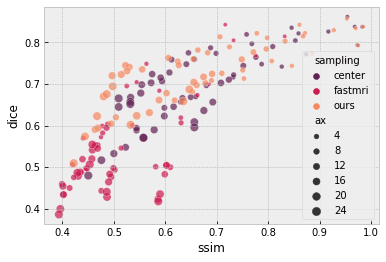

In [16]:
sns.scatterplot(data=dice_ssim_folds, x='ssim', y='dice', hue='sampling', size='ax', alpha=0.7, palette='rocket')
plt.show()

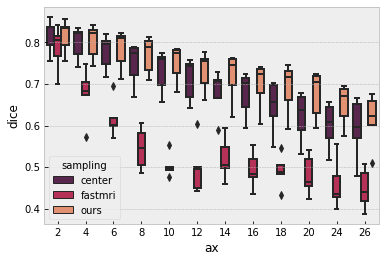

In [17]:
sns.boxplot(data=dice_ssim_folds, x='ax', y='dice', hue='sampling', palette='rocket')
plt.show()

In [21]:
import scipy
scipy.stats.ttest_rel(
    dice_ssim_folds[(dice_ssim_folds.ax==8) & (dice_ssim_folds.sampling=='center')].dice,
    dice_ssim_folds[(dice_ssim_folds.ax==8) & (dice_ssim_folds.sampling=='ours')].dice
)

Ttest_relResult(statistic=-4.043368742153179, pvalue=0.015560647394501016)

In [22]:
dice_ssim_folds[(dice_ssim_folds.ax==8) & (dice_ssim_folds.sampling=='center')]

,dice,ssim,ax,sampling,fold
3,0.786870,0.687826,8,center,0
15,0.669481,0.658946,8,center,1
27,0.721870,0.732587,8,center,2
39,0.773505,0.698474,8,center,3
51,0.789867,0.808547,8,center,4


In [23]:
dice_ssim_folds[(dice_ssim_folds.ax==8) & (dice_ssim_folds.sampling=='ours')]

,dice,ssim,ax,sampling,fold
123,0.813421,0.706162,8,ours,0
135,0.708315,0.689617,8,ours,1
147,0.733195,0.750351,8,ours,2
159,0.788966,0.724620,8,ours,3
171,0.802713,0.832618,8,ours,4
